In [1]:
import cv2 as cv
import numpy as np

import matplotlib.pyplot as plt
import os
import train_decentralised as td
import data.prepare_data as pdd
import torch

In [5]:
def get_centralised_loss(loss_option):
    path = "../exp_data/LocalSGD/centralised_training/"
    stat = sorted([v for v in os.listdir(path) if ".npy" in v])
    accu, loss_g, iteration = [], [], []
    for i, s_stat in enumerate(stat):
        value = np.load(path + s_stat, allow_pickle=True)
        iteration.append(int(s_stat.split("_")[-1].split(".npy")[0]))
        y, pred_prob = value 
        if loss_option == "1":
            loss = y * np.log(pred_prob + 1e-5)
        elif loss_option == "0":
            loss = (1-y)*np.log(1-pred_prob + 1e-5)
        else:
            loss = y * np.log(pred_prob + 1e-5) + (1-y)*np.log(1-pred_prob + 1e-5)
        accuracy = np.sum(y == (pred_prob >= 0.5).astype(np.int32)) / len(y)
        accu.append(accuracy)
        loss_g.append(np.mean(-loss))
    return np.array(accu[1:]), np.array(loss_g[1:]), np.array(iteration[1:])
        

In [6]:
def find_iteration(accu_g, iteration_g, crit, show=False):
    """Args:
    accu_g: [number of communication rounds]
    iteration_g: [number of communication roundsat]
    crit: single number
    """
    index = np.where(accu_g >= crit)[0]
    if len(index) > 0:
        if crit >= 0.8:
            index = index[0]
        else:
            index = index[-1]
        subset = np.linspace(accu_g[index-1], accu_g[index], 100)
        if crit >= 0.8:
            index_refine = np.where(subset >= crit)[0][0]
        else:
            index_refine = np.where(subset >= crit)[0][-1]
        iteration_use = np.linspace(iteration_g[index-1], iteration_g[index], 100)[index_refine]
    else:
        iteration_use = 1e+10
    if show:
        fig = plt.figure(figsize=(5, 3))
        ax = fig.add_subplot(111)
        ax.plot(iteration_g, accu_g, 'r-.')
        ax.plot(iteration_g, [crit for _ in iteration_g], 'g', ls=':')
        ax.plot([iteration_use], subset[index_refine], marker='*')
        print(iteration_use)
    return iteration_use




def calc_speedup(iteration_group, accuracy_group, centralised_iter, centralised_accu, crit, show):
    iteration_g = [find_iteration(s_accu, s_iter, crit) for s_accu, s_iter in zip(accuracy_group, iteration_group)]
    iteration_center = find_iteration(centralised_accu, centralised_iter,  crit, False)
    speed_up = iteration_center / np.array(iteration_g)
    if show:
        fig = plt.figure(figsize=(5, 3))
        ax = fig.add_subplot(111)
        for i in range(len(iteration_group)):
            ax.plot(iteration_group[i], accuracy_group[i],marker='.')
        for i, v in enumerate(iteration_g):
            if v < np.max(iteration_group[i]):
                ax.plot([v, v], [np.min(accuracy_group[i]), np.max(accuracy_group[i])], 
                        ls='--')
        ax.plot(centralised_iter, centralised_accu, color='k')
        ax.plot([iteration_center, iteration_center], 
                [np.min(centralised_accu), np.max(centralised_accu)], ls='--', color='k')
        ax.set_xlabel("Iterations")
        ax.set_ylabel("Accuracy")
        ax.set_xscale("symlog")

    

In [26]:
import pickle
def get_statistics(num_device, version, iid, alpha, com_cost, loss_option, show=False):
    path_mom = "/nobackup/blia/"
    decentralised_path = path_mom + "exp_data/LocalSGD/decentralised_training_iid_%s_alpha_%.1f/" % (iid, alpha)
    num_epoch = [1, 2, 4, 8, 16, 32]
    path_group = []
    path_select = sorted([v for v in os.listdir(decentralised_path) if "_%04d_devices" % num_device in v])
    stat = []
    iteration_group = []
    accuracy_group = []
    loss_group = []
    for i, s_epoch in enumerate(num_epoch):
        s_path = [v for v in path_select if "_%02d_epochs" % s_epoch in v and "0030_communication_rounds" in v][0]
        s_stat = pickle.load(open(decentralised_path + s_path + "/version_%d/statistics.obj" % version, 
                                  "rb"))
        _gt = s_stat["ground_truth"]
        _pred = s_stat["prediction_communication_round"]
        _loss_g = []
        if loss_option == "0":
            _loss_g = [-(1-_gt)*np.log(1-v+1e-5) for v in _pred]
        elif loss_option == "1":
            _loss_g = [-_gt * np.log(v + 1e-5) for v in _pred]
        else:
            _loss_g = [-(1-_gt)*np.log(1-v+1e-5) - _gt * np.log(v+1e-5) for v in _pred]

        _accu = [(_gt == (v >= 0.5).astype(np.int32)) for v in _pred]
        s_stat["accuracy"] = np.array(_accu)
        s_stat["loss"] = np.array(_loss_g)
        if not iid:
            iteration_g = [np.min([np.sum(s_stat["tr_distribution_non_iid"][i][0][1]), 
                                   np.sum(s_stat["tr_distribution_non_iid"][i][1][1])]
                                 ) for i in range(s_stat["communication_rounds"])]
            iteration_g = [s_stat["epoch"] * iteration_g[v-1] // 256 * v + com_cost * v for v in range(s_stat["communication_rounds"]+1)[1:]]
        else:
            iteration_g = [s_stat["epoch"] * s_stat["num_iter_per_epochs"] * v + com_cost * v for v in range(s_stat["communication_rounds"]+1)[1:]]

        iteration_group.append(iteration_g)
#         print("The shape of accuracy", np.shape(s_stat["accuracy"]), "The shape of the loss", np.shape(s_stat["loss"]))
        accuracy_group.append(np.mean(s_stat["accuracy"], axis=-1))
        loss_group.append(np.mean(s_stat["loss"], axis=-1))
        stat.append(s_stat)
    if show:
        fig = plt.figure(figsize=(5, 3))
        ax = fig.add_subplot(111)
        for i, s_epoch in enumerate(num_epoch):
            ax.plot(iteration_group[i], accuracy_group[i], label=s_epoch, marker='.')
        ax.legend(loc='best')
        ax.set_xlabel("Iterations")
        ax.set_ylabel("Accuracy")
        ax.set_xscale("symlog")
    return accuracy_group, loss_group, iteration_group, stat


def get_stat_multiple_version(num_device, version_group, iid, alpha, crit, com_cost, loss_option, 
                              show=False):
    accu_g, loss_g, iterr_g, steps = [], [], [], []
    for i, s_version in enumerate(version_group):
        _accu, _loss, _iterr, _ = get_statistics(num_device, s_version, iid, alpha, com_cost, loss_option, 
                                                 show=show)
        if crit > 0.80:
            iteration_g = [find_iteration(s_accu, s_iter, crit) for s_accu, s_iter in zip(_accu, _iterr)]
        else:
            iteration_g = [find_iteration(s_loss, s_iter, crit) for s_loss, s_iter in zip(_loss, _iterr)]
        steps.append(np.array(iteration_g))
        accu_g.append(_accu)
        loss_g.append(_loss)
        iterr_g.append(_iterr)
    iter_avg = np.mean(iterr_g, axis=0)
    accu_avg = np.mean(accu_g, axis=0)
    loss_avg = np.mean(loss_g, axis=0)
    if crit > 0.80:
        step_after_avg = [find_iteration(s_accu, s_iter, crit) for s_accu, s_iter in zip(accu_avg, iter_avg)]
    else:
        step_after_avg = [find_iteration(s_loss, s_iter, crit) for s_loss, s_iter in zip(loss_avg, iter_avg)]
    return iterr_g, accu_g, loss_g, steps, step_after_avg


def get_stat_multiple_devices_multiple_version(device_group, version_group, iid, alpha, crit, 
                                               com_cost, loss_option, 
                                               show=False, save=True):
    epoch_g = [1, 2, 4, 8, 16, 32]
    centralised_accu, centralised_loss, centralised_iter = get_centralised_loss(loss_option)
    if crit > 0.80:
        centralised_step = find_iteration(centralised_accu, centralised_iter, 
                                         crit, show=False)
    else:
        centralised_step = find_iteration(centralised_loss, centralised_iter, 
                                         crit, show=False)
    steps_require_to_achieve_crit = []
    iterr_group, accu_group, loss_group = [], [], []
    color_g = ['r', 'g', 'b', 'm', 'orange', 'lime', 'royalblue']
    
    for i, s_device in enumerate(device_group):
        iterr_s_device, accu_s_device, loss_s_device, _, step_after_avg = get_stat_multiple_version(s_device,
                                                                                     version_group, 
                                                                                     iid, alpha, crit, 
                                                                                     com_cost,
                                                                                     loss_option,
                                                                                     show=False)
        iterr_group.append(iterr_s_device)
        accu_group.append(accu_s_device)
        loss_group.append(loss_s_device)
        steps_require_to_achieve_crit.append(step_after_avg)
    steps_require_to_achieve_crit = np.array(steps_require_to_achieve_crit)
    print("The shape of the dcentralised", np.shape(steps_require_to_achieve_crit))
    print("The shape of centralised ", np.shape(centralised_iter), np.shape(centralised_accu), np.shape(centralised_loss))
    if show:
        fig = plt.figure(figsize=(5, 4))
        ax = fig.add_subplot(111)
        for i in range(len(step_after_avg)):
            ax.plot(device_group, centralised_step / steps_require_to_achieve_crit[:, i], 
                    color=color_g[i], marker='^', label="H=%d" % epoch_g[i])
        ax.legend(loc='best')
        ax.plot(device_group, device_group, ls='--', color='k')
        ax.grid(ls=':', axis='both')
        ax.set_xlabel("Number of workers")
        ax.set_ylabel("Measured speed up")
        if save:
            plt.savefig("calculate_speed_up_iid_%s_alpha_%.1f_crit_%.2f.pdf" % (iid, alpha, crit), pad_inches=0, 
                       bbox_inches='tight')
        
        fig = plt.figure(figsize=(10, 10))
        for iterr, select_device in enumerate([2, 4, 8, 16]):
            ax = fig.add_subplot( len(device_group), 1,iterr+1)
            ind_to_show = np.where(device_group == select_device)[0][0]
            iterr_avg, accu_avg = np.mean(iterr_group[ind_to_show], axis=0), np.mean(accu_group[ind_to_show], axis=0)
            for i, s_epoch in enumerate(epoch_g):
                ax.plot(iterr_avg[i], accu_avg[i], color=color_g[i], 
                        marker='.', label="K:%d, H:%d" % (select_device, s_epoch))
            ax.plot(centralised_iter, centralised_accu,
                    marker='.',color='k', label="K:1, H:1")
            ax.grid(ls=':')
            ax.legend(loc='best')
            ax.set_xlabel("Iterations")
            ax.set_ylabel("Accuracy")
            ax.set_xscale("symlog")

        fig = plt.figure(figsize=(10, 10))
        for iterr, select_device in enumerate([2, 4, 8, 16]):
            ax = fig.add_subplot(len(device_group),1,  iterr+1)
            ind_to_show = np.where(device_group == select_device)[0][0]
            iterr_avg, accu_avg = np.mean(iterr_group[ind_to_show], axis=0), np.mean(loss_group[ind_to_show], axis=0)
            print(np.shape(iterr_avg), np.shape(accu_avg), np.max(accu_avg), np.min(accu_avg))
            for i, s_epoch in enumerate(epoch_g):
                ax.plot(iterr_avg[i], accu_avg[i], color=color_g[i], 
                        marker='.', label="K:%d, H:%d" % (select_device, s_epoch))
            ax.plot(centralised_iter, centralised_loss, 
                    marker='.',color='k', label="K:1, H:1")
            if crit < 0.80:
                ax.plot([np.min(iterr_avg), np.max(iterr_avg)], [crit, crit], ls=':')
            ax.grid(ls=':')
            ax.legend(loc='best')
            ax.set_xlabel("Iterations")
            ax.set_ylabel("Loss")
            ax.set_xscale("symlog")
            ax.set_yscale("log")
    return iterr_group, loss_group, accu_group

The shape of the dcentralised (4, 6)
The shape of centralised  (50,) (50,) (50,)


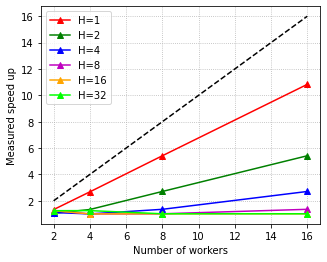

In [27]:
_out = get_stat_multiple_devices_multiple_version(device_group=np.array([2, 4, 8, 16]), 
                                                  version_group=[0], 
                                                  iid=True, alpha=0.0, 
                                                  crit=0.22, 
                                                  com_cost=0, 
                                                  loss_option="both", 
                                                  show=True, save=True)
# get_stat_multiple_devices_multiple_version(np.array([2, 4, 8]), [0], False, 0.1, 0.92, show=True, save=False)